# Implementing DCGAN

In this notebook, we are implementing DCGAN for Shoes dataset with size of 28701 images. 

### Step 1: Import the needed libraries 


In [1]:
from keras import backend as K
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import MaxPooling2D, UpSampling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model, Sequential
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math   
import os
from tqdm import tqdm


# Evaluation
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from numpy import log, ones, expand_dims, mean, exp, std
from math import floor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# using euclidian distance 
from sklearn.model_selection import LeaveOneOut

initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
%matplotlib inline

### Step 2: Data Loading
The data used in this notebook is the cleaned one with around 14000 images 

In [2]:
# load Fashion Product Images dataset
width=100
batch_size=32 # batch size of image generator = batch size of GAN
path = '/home/group6/G.Deep Learning/Project/Shoes-dataset'
Img_generator=ImageDataGenerator(rescale=1./255)
train_gen=Img_generator.flow_from_directory(path, classes=[''], target_size=(width,width),batch_size=batch_size,shuffle=False)

Found 28701 images belonging to 1 classes.


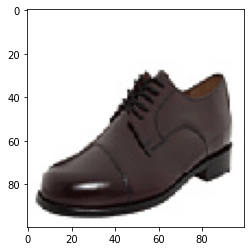

In [3]:
d = (train_gen.next())
train_gen.reset()
d[0][0].shape
plt.imshow(d[0][0])

In [4]:
img_shape = (width, width, 3)
z_dim = 256
num_batches = math.floor(28701/batch_size)
num_batches

896

### Step 3: DCGAN Implementation


### Generator

In [5]:
def build_generator(input_shape, inputs=(100, )):
    """Build a Generator Model
    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.
    Arguments:
        inputs (Layer): Input layer of the generator 
            the z-vector)
        image_size (tensor): Target size of one side
            (assuming square image)
    Returns:
        generator (Model): Generator Model
    """
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 3]
   
    # We will start with 7x7x128 and upscale to 28x28x1 evantually
    inputs = Input(shape=inputs, name='Generator')
    print(input_shape[0])
    print(layer_filters[0])
    resize = input_shape[0] // 4
    x = Dense(resize * resize * layer_filters[0])(inputs)
    x = Reshape((resize, resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    generator.summary()
    return generator

### Discriminator

In [6]:
def build_discriminator(input_shape = (100, 100 ,3)):
    """Build a Discriminator Model
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.
    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256, 512]  #[32, 64, 128, 256]

    inputs = Input(shape=input_shape, name='discriminator_input')
    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = Activation('relu')(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
#     x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    discriminator.summary()
    return discriminator

### Training 

In [7]:
accuracies = []
losses = []
def train(train_gen, epochs, generator_batch_size, ite_to_save=100):
    real = np.ones(shape=(generator_batch_size, 1))
    fake = np.zeros(shape=(generator_batch_size, 1))
    
    for epoch in tqdm(range(epochs)):
        train_gen.reset() #To insure that we start again from the same batch (0)
        for batch in range(num_batches):
            #load current batch
            x_train = train_gen.next()
        
            real_images=x_train[0][0:generator_batch_size]   
            
            z = np.random.normal(0, 1, size=[generator_batch_size, z_dim])
            gen_imgs = gen.predict(z)
        
            d_loss_real = disc.train_on_batch(real_images, real)
            d_loss_fake = disc.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
            z = np.random.normal(0, 1, size=[generator_batch_size, z_dim])
        
            g_loss = DCGAN.train_on_batch(z, real)
            
        print('{} [D loss: {}, accuracy: {:.2f}] [Adv loss: {}, Adv accuracy: {:.2f}]'.format(epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1]))
        
        losses.append([d_loss[0], g_loss[0]])
        accuracies.append([d_loss[1], g_loss[1]])
        if epoch % ite_to_save == 0:    
            plot_images(gen,
                z,
                show=True,
                file_name="images/Latent256FINAL/Epoch_{}.png".format(epoch))
            disc.save('savedModelsDCLatent256FINAL/dcdisc_{}.h5'.format(epoch))  
            gen.save('savedModelsDCLatent256FINAL/dcgen_{}.h5'.format(epoch))  
            DCGAN.save('savedModelsDCLatent256FINAL/dcGAN_{}.h5'.format(epoch))   
    

### Plot Images

In [8]:
# predict images
def plot_images(generator,
                noise_input,
                show=False,
                file_name="images/Latent256/Epoch_1.png"):
    z = noise_input
    gen_imgs = generator.predict(z)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig(file_name)    
    plt.show()

### Building the model

In [9]:
# Building and compiling the discriminator
# Since there are only two classes
lr = 2e-4
decay = 6e-8

disc = build_discriminator(img_shape) 
#discriminator = define_discriminator() 
disc.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0001, beta_1=0.5), 
                      metrics=['accuracy']) 

#Making the Discriminator untrainable 
#so that the generator can learn from fixed gradient 
disc.trainable = False
  
# Building the generator 
gen = build_generator(img_shape, (z_dim, ))
  
#Defining the input for the generator 
#and generating the images 
z = Input(shape=(z_dim,)) 
print("Z=", z)
image = gen(z)
print("Image=", image)
print("Image SHAPE {}".format(image.shape))
#Checking the validity of the generated image
#Feed the image into the discriminator

valid = disc(image)
print("Valid=",valid)
  
#Defining the combined model of the Generator and the Discriminator 
DCGAN = Model(z, valid) 
DCGAN.compile(loss='binary_crossentropy', 
                         optimizer=Adam(0.0001, beta_1=0.5),
                         metrics=['accuracy']) 


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 100, 100, 3)]     0         
_________________________________________________________________
activation (Activation)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)     

### Start Training

  0%|          | 0/401 [00:00<?, ?it/s]

0 [D loss: 0.038466399535536766, accuracy: 100.00] [Adv loss: 0.08198653161525726, Adv accuracy: 100.00]


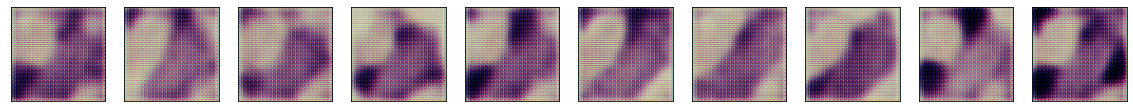

  0%|          | 2/401 [04:47<15:51:55, 143.15s/it]

1 [D loss: 0.029746961779892445, accuracy: 98.44] [Adv loss: 0.022546496242284775, Adv accuracy: 100.00]


  1%|          | 3/401 [07:07<15:40:12, 141.74s/it]

2 [D loss: 0.0018342842085985467, accuracy: 100.00] [Adv loss: 0.04346136748790741, Adv accuracy: 100.00]


  1%|          | 4/401 [09:28<15:34:04, 141.17s/it]

3 [D loss: 0.4386497288942337, accuracy: 82.81] [Adv loss: 1.6947433948516846, Adv accuracy: 0.00]


  1%|          | 5/401 [11:48<15:30:31, 140.99s/it]

4 [D loss: 0.19820277392864227, accuracy: 90.62] [Adv loss: 3.583890438079834, Adv accuracy: 0.00]
5 [D loss: 0.00012186942578296112, accuracy: 100.00] [Adv loss: 0.007176310755312443, Adv accuracy: 100.00]


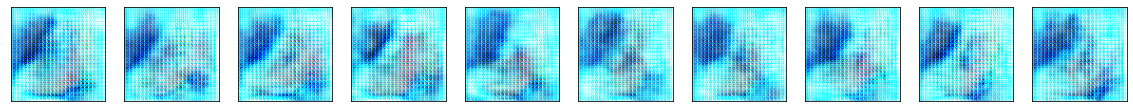

  2%|▏         | 7/401 [16:31<15:26:24, 141.08s/it]

6 [D loss: 0.14090218767523766, accuracy: 95.31] [Adv loss: 0.14294590055942535, Adv accuracy: 93.75]


  2%|▏         | 8/401 [18:52<15:23:47, 141.04s/it]

7 [D loss: 0.32415740191936493, accuracy: 87.50] [Adv loss: 3.8687124252319336, Adv accuracy: 0.00]


  2%|▏         | 9/401 [21:13<15:20:56, 140.96s/it]

8 [D loss: 0.16695526242256165, accuracy: 92.19] [Adv loss: 3.5178370475769043, Adv accuracy: 0.00]


  2%|▏         | 10/401 [23:33<15:18:15, 140.91s/it]

9 [D loss: 0.2540656253695488, accuracy: 90.62] [Adv loss: 3.444431781768799, Adv accuracy: 0.00]
10 [D loss: 0.02122434228658676, accuracy: 98.44] [Adv loss: 6.592105865478516, Adv accuracy: 0.00]


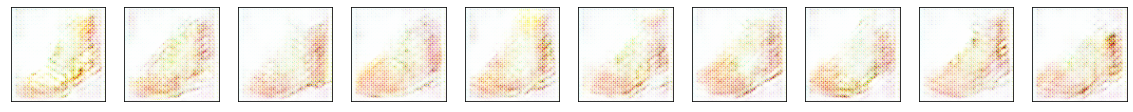

  3%|▎         | 12/401 [28:15<15:13:17, 140.87s/it]

11 [D loss: 0.13280711136758327, accuracy: 95.31] [Adv loss: 1.340264081954956, Adv accuracy: 28.12]


  3%|▎         | 13/401 [30:37<15:11:42, 140.98s/it]

12 [D loss: 0.23133961483836174, accuracy: 93.75] [Adv loss: 3.441183567047119, Adv accuracy: 0.00]


  3%|▎         | 14/401 [32:57<15:08:04, 140.79s/it]

13 [D loss: 0.014985452115070075, accuracy: 100.00] [Adv loss: 0.1129830852150917, Adv accuracy: 96.88]


  4%|▎         | 15/401 [35:18<15:06:04, 140.84s/it]

14 [D loss: 0.0028643750702030957, accuracy: 100.00] [Adv loss: 0.0016592296306043863, Adv accuracy: 100.00]
15 [D loss: 0.0006543307972606272, accuracy: 100.00] [Adv loss: 0.18460962176322937, Adv accuracy: 93.75]


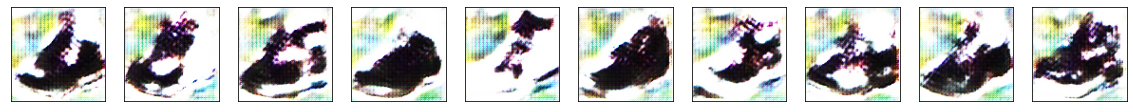

  4%|▍         | 17/401 [40:00<15:01:45, 140.90s/it]

16 [D loss: 0.08581448905169964, accuracy: 96.88] [Adv loss: 0.18153122067451477, Adv accuracy: 100.00]


  4%|▍         | 18/401 [42:21<14:59:32, 140.92s/it]

17 [D loss: 0.02829841338098049, accuracy: 98.44] [Adv loss: 2.776862382888794, Adv accuracy: 0.00]


  5%|▍         | 19/401 [44:42<14:57:26, 140.96s/it]

18 [D loss: 0.0119027603068389, accuracy: 100.00] [Adv loss: 0.0045043774880468845, Adv accuracy: 100.00]


  5%|▍         | 20/401 [47:03<14:54:30, 140.87s/it]

19 [D loss: 0.0003724524503923021, accuracy: 100.00] [Adv loss: 0.007754298858344555, Adv accuracy: 100.00]
20 [D loss: 0.12496669590473175, accuracy: 95.31] [Adv loss: 0.09494160860776901, Adv accuracy: 100.00]


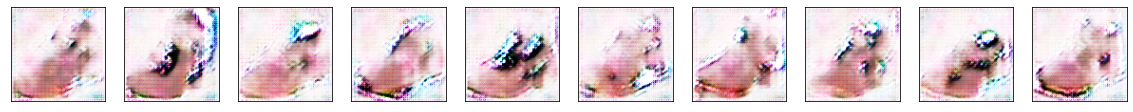

  5%|▌         | 22/401 [51:45<14:49:58, 140.89s/it]

21 [D loss: 0.019046022556722164, accuracy: 100.00] [Adv loss: 0.1318199336528778, Adv accuracy: 100.00]


  6%|▌         | 23/401 [54:06<14:47:43, 140.91s/it]

22 [D loss: 0.002598085207864642, accuracy: 100.00] [Adv loss: 0.0006540361209772527, Adv accuracy: 100.00]


  6%|▌         | 24/401 [56:27<14:46:18, 141.06s/it]

23 [D loss: 0.265127994120121, accuracy: 89.06] [Adv loss: 2.843596935272217, Adv accuracy: 0.00]


  6%|▌         | 25/401 [58:48<14:43:14, 140.94s/it]

24 [D loss: 0.013564059743657708, accuracy: 100.00] [Adv loss: 0.030155088752508163, Adv accuracy: 100.00]
25 [D loss: 0.0012784396167262457, accuracy: 100.00] [Adv loss: 0.13158711791038513, Adv accuracy: 93.75]


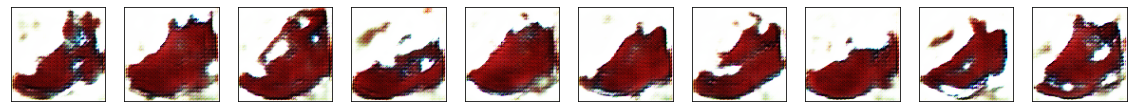

  7%|▋         | 27/401 [1:03:31<14:40:40, 141.28s/it]

26 [D loss: 0.14172015897929668, accuracy: 93.75] [Adv loss: 0.0387711338698864, Adv accuracy: 96.88]


  7%|▋         | 28/401 [1:05:52<14:37:47, 141.20s/it]

27 [D loss: 0.008337524253875017, accuracy: 100.00] [Adv loss: 4.097133159637451, Adv accuracy: 0.00]


  7%|▋         | 29/401 [1:08:14<14:35:40, 141.24s/it]

28 [D loss: 0.04672117345035076, accuracy: 98.44] [Adv loss: 0.3347148299217224, Adv accuracy: 90.62]


  7%|▋         | 30/401 [1:10:34<14:32:36, 141.12s/it]

29 [D loss: 0.004027400049380958, accuracy: 100.00] [Adv loss: 0.014078016392886639, Adv accuracy: 100.00]
30 [D loss: 0.0025645965069998056, accuracy: 100.00] [Adv loss: 0.12504972517490387, Adv accuracy: 90.62]


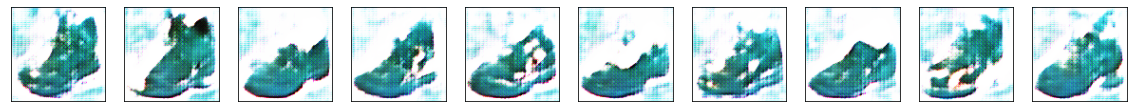

  8%|▊         | 32/401 [1:15:17<14:28:46, 141.27s/it]

31 [D loss: 0.00047827535308897495, accuracy: 100.00] [Adv loss: 0.04185498505830765, Adv accuracy: 96.88]


  8%|▊         | 33/401 [1:17:39<14:26:43, 141.31s/it]

32 [D loss: 0.004000637913122773, accuracy: 100.00] [Adv loss: 0.09213950484991074, Adv accuracy: 96.88]


  8%|▊         | 34/401 [1:20:00<14:24:22, 141.31s/it]

33 [D loss: 0.1089900704100728, accuracy: 95.31] [Adv loss: 5.8775506019592285, Adv accuracy: 3.12]


  9%|▊         | 35/401 [1:22:22<14:22:49, 141.45s/it]

34 [D loss: 0.059797641122713685, accuracy: 98.44] [Adv loss: 0.0034075486473739147, Adv accuracy: 100.00]
35 [D loss: 0.001157927152235061, accuracy: 100.00] [Adv loss: 0.17348062992095947, Adv accuracy: 96.88]


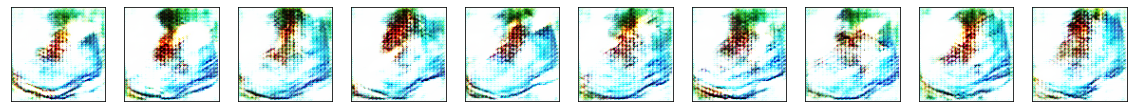

  9%|▉         | 37/401 [1:27:05<14:18:39, 141.54s/it]

36 [D loss: 9.152347865892807e-05, accuracy: 100.00] [Adv loss: 0.00026753591373562813, Adv accuracy: 100.00]


  9%|▉         | 38/401 [1:29:27<14:16:23, 141.55s/it]

37 [D loss: 0.18267373740673065, accuracy: 95.31] [Adv loss: 0.38575297594070435, Adv accuracy: 78.12]


 10%|▉         | 39/401 [1:31:49<14:14:21, 141.61s/it]

38 [D loss: 0.02430148981511593, accuracy: 100.00] [Adv loss: 0.02250225841999054, Adv accuracy: 100.00]


 10%|▉         | 40/401 [1:34:10<14:11:21, 141.50s/it]

39 [D loss: 0.00012250063991814386, accuracy: 100.00] [Adv loss: 5.122477659824654e-07, Adv accuracy: 100.00]
40 [D loss: 0.28472719714045525, accuracy: 89.06] [Adv loss: 6.333895206451416, Adv accuracy: 0.00]


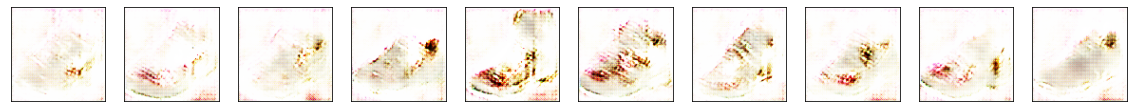

 10%|█         | 42/401 [1:38:55<14:09:31, 141.98s/it]

41 [D loss: 0.6036985740065575, accuracy: 78.12] [Adv loss: 15.769010543823242, Adv accuracy: 0.00]


 11%|█         | 43/401 [1:41:17<14:07:16, 142.00s/it]

42 [D loss: 0.004119922174140811, accuracy: 100.00] [Adv loss: 0.22657814621925354, Adv accuracy: 93.75]


 11%|█         | 44/401 [1:43:39<14:04:31, 141.94s/it]

43 [D loss: 0.006858921842649579, accuracy: 100.00] [Adv loss: 0.4830347001552582, Adv accuracy: 78.12]


 11%|█         | 45/401 [1:46:01<14:02:22, 141.97s/it]

44 [D loss: 0.0010927595722023398, accuracy: 100.00] [Adv loss: 0.02941899374127388, Adv accuracy: 100.00]
45 [D loss: 0.00437606917694211, accuracy: 100.00] [Adv loss: 0.2379392385482788, Adv accuracy: 90.62]


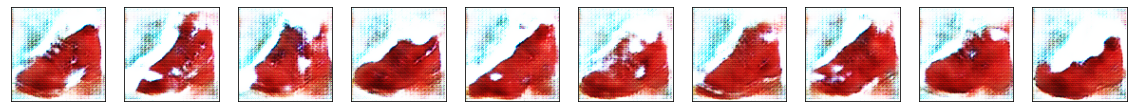

 12%|█▏        | 47/401 [1:50:45<13:58:04, 142.05s/it]

46 [D loss: 0.0008359435560123529, accuracy: 100.00] [Adv loss: 0.04742627590894699, Adv accuracy: 100.00]


 12%|█▏        | 48/401 [1:53:07<13:56:03, 142.11s/it]

47 [D loss: 0.4800608158111572, accuracy: 82.81] [Adv loss: 8.31861686706543, Adv accuracy: 0.00]


 12%|█▏        | 49/401 [1:55:30<13:53:56, 142.15s/it]

48 [D loss: 0.2562488615512848, accuracy: 89.06] [Adv loss: 3.4367756843566895, Adv accuracy: 3.12]


 12%|█▏        | 50/401 [1:57:51<13:50:32, 141.97s/it]

49 [D loss: 0.012136808596551418, accuracy: 100.00] [Adv loss: 2.3075928766047582e-05, Adv accuracy: 100.00]
50 [D loss: 0.0007180431493907236, accuracy: 100.00] [Adv loss: 0.007040375843644142, Adv accuracy: 100.00]


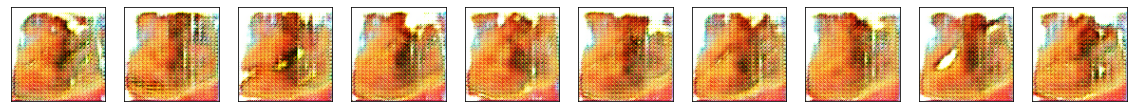

 13%|█▎        | 52/401 [2:02:36<13:45:56, 142.00s/it]

51 [D loss: 0.008208540501073003, accuracy: 100.00] [Adv loss: 1.4072470664978027, Adv accuracy: 25.00]


 13%|█▎        | 53/401 [2:04:58<13:44:02, 142.08s/it]

52 [D loss: 0.286721333861351, accuracy: 85.94] [Adv loss: 2.618157386779785, Adv accuracy: 0.00]


 13%|█▎        | 54/401 [2:07:21<13:43:17, 142.35s/it]

53 [D loss: 0.003718540072441101, accuracy: 100.00] [Adv loss: 3.8078267574310303, Adv accuracy: 0.00]


 14%|█▎        | 55/401 [2:09:43<13:40:57, 142.36s/it]

54 [D loss: 0.02610546862706542, accuracy: 100.00] [Adv loss: 0.02875281311571598, Adv accuracy: 100.00]
55 [D loss: 0.238385995849967, accuracy: 93.75] [Adv loss: 0.9839304089546204, Adv accuracy: 53.12]


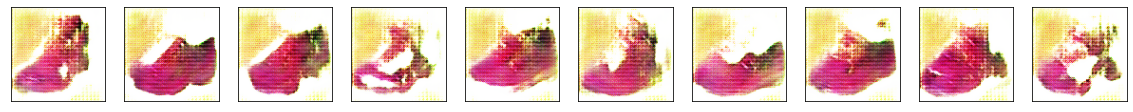

 14%|█▍        | 57/401 [2:14:28<13:35:46, 142.29s/it]

56 [D loss: 0.011446292046457529, accuracy: 100.00] [Adv loss: 5.281926155090332, Adv accuracy: 0.00]


 14%|█▍        | 58/401 [2:16:50<13:33:01, 142.22s/it]

57 [D loss: 0.00032410574931418523, accuracy: 100.00] [Adv loss: 0.2857237458229065, Adv accuracy: 90.62]


 15%|█▍        | 59/401 [2:19:12<13:30:09, 142.13s/it]

58 [D loss: 0.0042039366089738905, accuracy: 100.00] [Adv loss: 0.24649587273597717, Adv accuracy: 87.50]


 15%|█▍        | 60/401 [2:21:34<13:28:03, 142.18s/it]

59 [D loss: 0.09672874212265015, accuracy: 95.31] [Adv loss: 0.013020409271121025, Adv accuracy: 100.00]
60 [D loss: 0.15455393493175507, accuracy: 93.75] [Adv loss: 0.41408199071884155, Adv accuracy: 87.50]


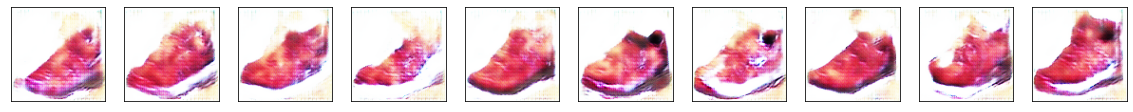

 15%|█▌        | 62/401 [2:26:20<13:24:38, 142.42s/it]

61 [D loss: 0.0005038105882704258, accuracy: 100.00] [Adv loss: 0.11642498522996902, Adv accuracy: 96.88]


 16%|█▌        | 63/401 [2:28:42<13:22:17, 142.42s/it]

62 [D loss: 8.919059564505005e-05, accuracy: 100.00] [Adv loss: 0.00019053681171499193, Adv accuracy: 100.00]


 16%|█▌        | 64/401 [2:31:04<13:19:32, 142.35s/it]

63 [D loss: 0.1890870314091444, accuracy: 90.62] [Adv loss: 14.775252342224121, Adv accuracy: 0.00]


 16%|█▌        | 65/401 [2:33:27<13:17:35, 142.43s/it]

64 [D loss: 0.0057875660713762045, accuracy: 100.00] [Adv loss: 0.5150133371353149, Adv accuracy: 78.12]
65 [D loss: 0.0038550751269212924, accuracy: 100.00] [Adv loss: 0.5686038732528687, Adv accuracy: 78.12]


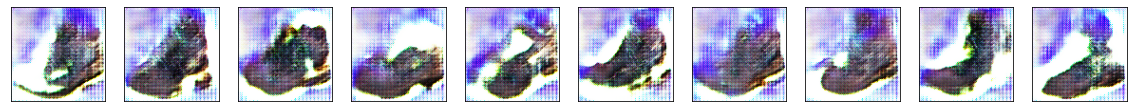

 17%|█▋        | 67/401 [2:38:12<13:13:00, 142.46s/it]

66 [D loss: 0.13946856185793877, accuracy: 95.31] [Adv loss: 2.8780393600463867, Adv accuracy: 9.38]


 17%|█▋        | 68/401 [2:40:35<13:11:37, 142.63s/it]

67 [D loss: 2.3637133952494893e-05, accuracy: 100.00] [Adv loss: 0.01808006502687931, Adv accuracy: 100.00]


 17%|█▋        | 69/401 [2:42:57<13:08:57, 142.58s/it]

68 [D loss: 0.014173789299093187, accuracy: 100.00] [Adv loss: 0.9306761026382446, Adv accuracy: 65.62]


 17%|█▋        | 70/401 [2:45:20<13:06:33, 142.58s/it]

69 [D loss: 0.07485014945268631, accuracy: 96.88] [Adv loss: 2.874691963195801, Adv accuracy: 6.25]
70 [D loss: 0.002704207960050553, accuracy: 100.00] [Adv loss: 0.05322388559579849, Adv accuracy: 96.88]


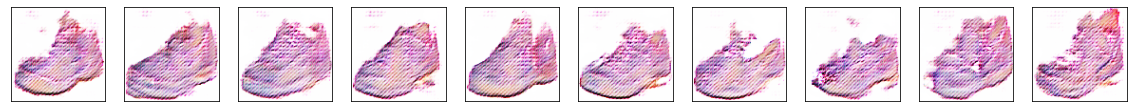

 18%|█▊        | 72/401 [2:50:06<13:02:57, 142.79s/it]

71 [D loss: 0.012748183216899633, accuracy: 100.00] [Adv loss: 7.252502918243408, Adv accuracy: 0.00]


 18%|█▊        | 73/401 [2:52:28<12:59:56, 142.67s/it]

72 [D loss: 0.09766005259007215, accuracy: 96.88] [Adv loss: 4.471975326538086, Adv accuracy: 3.12]


 18%|█▊        | 74/401 [2:54:51<12:57:40, 142.69s/it]

73 [D loss: 0.0003370385152138382, accuracy: 100.00] [Adv loss: 8.832828521728516, Adv accuracy: 6.25]


 19%|█▊        | 75/401 [2:57:14<12:55:01, 142.64s/it]

74 [D loss: 0.0016848452074782472, accuracy: 100.00] [Adv loss: 0.002472724299877882, Adv accuracy: 100.00]
75 [D loss: 0.00012361850258457707, accuracy: 100.00] [Adv loss: 0.04426955431699753, Adv accuracy: 100.00]


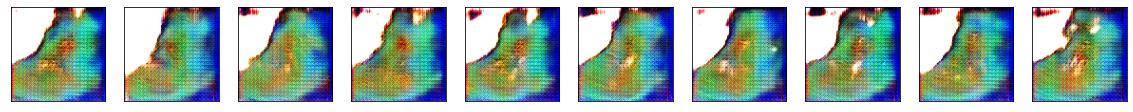

 19%|█▉        | 77/401 [3:02:00<12:50:49, 142.75s/it]

76 [D loss: 0.00015975548055280342, accuracy: 100.00] [Adv loss: 0.12533734738826752, Adv accuracy: 90.62]


 19%|█▉        | 78/401 [3:04:22<12:48:23, 142.74s/it]

77 [D loss: 0.00025239195383619517, accuracy: 100.00] [Adv loss: 2.119003530602566e-16, Adv accuracy: 100.00]


 20%|█▉        | 79/401 [3:06:45<12:45:26, 142.63s/it]

78 [D loss: 4.653561882150825e-05, accuracy: 100.00] [Adv loss: 7.023125171661377, Adv accuracy: 0.00]


 20%|█▉        | 80/401 [3:09:07<12:42:44, 142.57s/it]

79 [D loss: 0.000470730123197427, accuracy: 100.00] [Adv loss: 0.004164094105362892, Adv accuracy: 100.00]
80 [D loss: 0.09403931722044945, accuracy: 96.88] [Adv loss: 3.5029187202453613, Adv accuracy: 3.12]


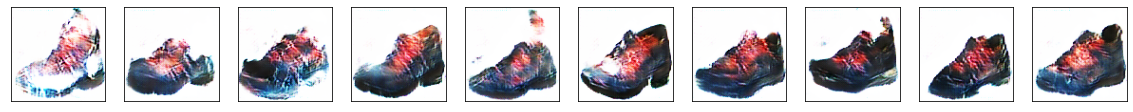

 20%|██        | 82/401 [3:13:53<12:39:28, 142.85s/it]

81 [D loss: 6.552693594130687e-05, accuracy: 100.00] [Adv loss: 0.006361507344990969, Adv accuracy: 100.00]


 21%|██        | 83/401 [3:16:16<12:36:36, 142.75s/it]

82 [D loss: 0.010414592223241925, accuracy: 100.00] [Adv loss: 2.4485831090714782e-05, Adv accuracy: 100.00]


 21%|██        | 84/401 [3:18:39<12:34:30, 142.81s/it]

83 [D loss: 0.0011870663147419691, accuracy: 100.00] [Adv loss: 2.7891236542565423e-10, Adv accuracy: 100.00]


 21%|██        | 85/401 [3:21:01<12:31:38, 142.72s/it]

84 [D loss: 0.5861313939094543, accuracy: 67.19] [Adv loss: 9.88614273071289, Adv accuracy: 0.00]
85 [D loss: 0.4052567407488823, accuracy: 87.50] [Adv loss: 4.030154228210449, Adv accuracy: 3.12]


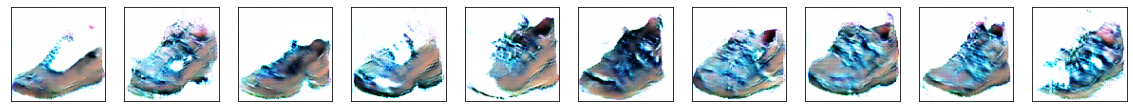

 22%|██▏       | 87/401 [3:25:48<12:27:38, 142.86s/it]

86 [D loss: 0.03686279430985451, accuracy: 98.44] [Adv loss: 4.047688007354736, Adv accuracy: 0.00]


 22%|██▏       | 88/401 [3:28:10<12:24:50, 142.78s/it]

87 [D loss: 0.22932714223861694, accuracy: 90.62] [Adv loss: 4.168932914733887, Adv accuracy: 3.12]


 22%|██▏       | 89/401 [3:30:33<12:22:11, 142.73s/it]

88 [D loss: 0.36298293620347977, accuracy: 85.94] [Adv loss: 2.0766239166259766, Adv accuracy: 18.75]


 22%|██▏       | 90/401 [3:32:55<12:19:20, 142.64s/it]

89 [D loss: 0.1171580795198679, accuracy: 93.75] [Adv loss: 1.4916579723358154, Adv accuracy: 40.62]
90 [D loss: 0.05534632783383131, accuracy: 98.44] [Adv loss: 6.474152088165283, Adv accuracy: 0.00]


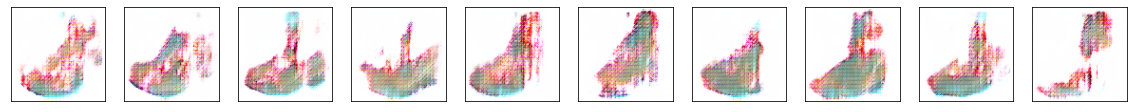

 23%|██▎       | 92/401 [3:37:41<12:15:12, 142.76s/it]

91 [D loss: 0.07596244663000107, accuracy: 93.75] [Adv loss: 5.245490074157715, Adv accuracy: 0.00]


 23%|██▎       | 93/401 [3:40:05<12:13:58, 142.98s/it]

92 [D loss: 0.00015386617724288953, accuracy: 100.00] [Adv loss: 0.00036104442551732063, Adv accuracy: 100.00]


 23%|██▎       | 94/401 [3:42:28<12:12:00, 143.06s/it]

93 [D loss: 0.005101272487081587, accuracy: 100.00] [Adv loss: 4.9924235343933105, Adv accuracy: 0.00]


 24%|██▎       | 95/401 [3:44:51<12:09:33, 143.05s/it]

94 [D loss: 0.00038355269134626724, accuracy: 100.00] [Adv loss: 0.005336648318916559, Adv accuracy: 100.00]
95 [D loss: 0.6472467184066772, accuracy: 70.31] [Adv loss: 6.942877769470215, Adv accuracy: 3.12]


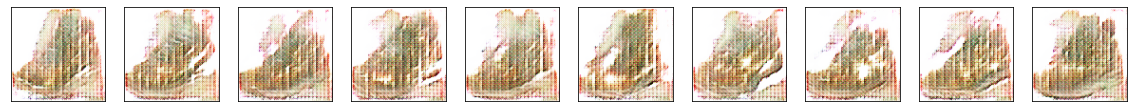

 24%|██▍       | 97/401 [3:49:36<12:03:43, 142.84s/it]

96 [D loss: 0.0004948138112208511, accuracy: 100.00] [Adv loss: 0.018951889127492905, Adv accuracy: 100.00]


 24%|██▍       | 98/401 [3:51:59<12:01:16, 142.83s/it]

97 [D loss: 0.20876051113009453, accuracy: 95.31] [Adv loss: 4.67400598526001, Adv accuracy: 3.12]


 25%|██▍       | 99/401 [3:54:22<11:59:13, 142.89s/it]

98 [D loss: 0.0017920561258506496, accuracy: 100.00] [Adv loss: 0.007160205394029617, Adv accuracy: 100.00]


 25%|██▍       | 100/401 [3:56:45<11:56:40, 142.86s/it]

99 [D loss: 0.18049348890781403, accuracy: 92.19] [Adv loss: 4.3245391845703125, Adv accuracy: 9.38]
100 [D loss: 0.000805156771093607, accuracy: 100.00] [Adv loss: 0.9086916446685791, Adv accuracy: 50.00]


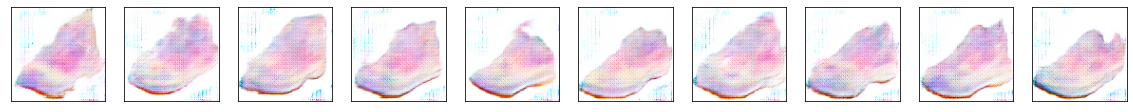

 25%|██▌       | 102/401 [4:01:31<11:52:37, 143.00s/it]

101 [D loss: 0.004200696850602981, accuracy: 100.00] [Adv loss: 0.3304530680179596, Adv accuracy: 87.50]


 26%|██▌       | 103/401 [4:03:54<11:49:50, 142.92s/it]

102 [D loss: 0.0013848541129846126, accuracy: 100.00] [Adv loss: 5.9793243408203125, Adv accuracy: 0.00]


 26%|██▌       | 104/401 [4:06:17<11:47:01, 142.83s/it]

103 [D loss: 0.018395819090073928, accuracy: 100.00] [Adv loss: 2.184131145477295, Adv accuracy: 46.88]


 26%|██▌       | 105/401 [4:08:39<11:44:38, 142.83s/it]

104 [D loss: 0.00010676143574570816, accuracy: 100.00] [Adv loss: 0.014496983960270882, Adv accuracy: 100.00]
105 [D loss: 0.010005746386013925, accuracy: 100.00] [Adv loss: 0.03715028613805771, Adv accuracy: 100.00]


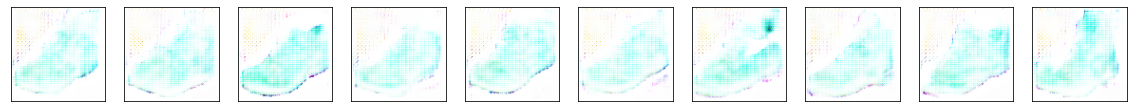

 27%|██▋       | 107/401 [4:13:25<11:39:50, 142.83s/it]

106 [D loss: 0.08632371528074145, accuracy: 96.88] [Adv loss: 3.764888048171997, Adv accuracy: 0.00]


 27%|██▋       | 108/401 [4:15:48<11:37:31, 142.84s/it]

107 [D loss: 0.04432780295610428, accuracy: 98.44] [Adv loss: 4.814727783203125, Adv accuracy: 0.00]


 27%|██▋       | 109/401 [4:18:11<11:34:43, 142.75s/it]

108 [D loss: 0.08475237677339464, accuracy: 95.31] [Adv loss: 0.8782927393913269, Adv accuracy: 59.38]


 27%|██▋       | 110/401 [4:20:33<11:32:13, 142.73s/it]

109 [D loss: 0.015648629516363144, accuracy: 98.44] [Adv loss: 4.2638678550720215, Adv accuracy: 3.12]
110 [D loss: 0.015504965665968484, accuracy: 98.44] [Adv loss: 1.3773924112319946, Adv accuracy: 62.50]


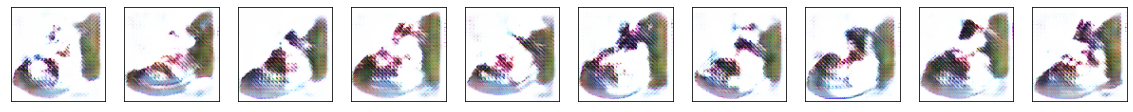

 28%|██▊       | 112/401 [4:25:19<11:27:14, 142.68s/it]

111 [D loss: 7.155717207751877e-05, accuracy: 100.00] [Adv loss: 0.011488872580230236, Adv accuracy: 100.00]


 28%|██▊       | 113/401 [4:27:42<11:25:02, 142.72s/it]

112 [D loss: 0.11402962356805801, accuracy: 96.88] [Adv loss: 3.9640092849731445, Adv accuracy: 3.12]


 28%|██▊       | 114/401 [4:30:05<11:23:11, 142.83s/it]

113 [D loss: 0.004683457547798753, accuracy: 100.00] [Adv loss: 3.894649028778076, Adv accuracy: 9.38]


 29%|██▊       | 115/401 [4:32:27<11:20:26, 142.75s/it]

114 [D loss: 5.719865297311849e-05, accuracy: 100.00] [Adv loss: 0.24490226805210114, Adv accuracy: 93.75]
115 [D loss: 0.05659359034325462, accuracy: 95.31] [Adv loss: 1.0414923963253386e-05, Adv accuracy: 100.00]


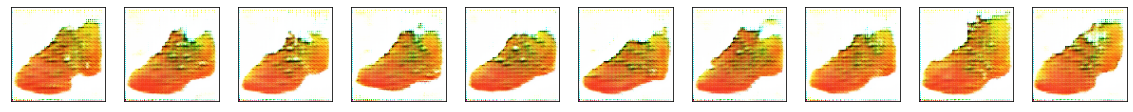

 29%|██▉       | 117/401 [4:37:14<11:16:34, 142.94s/it]

116 [D loss: 0.00048376922495663166, accuracy: 100.00] [Adv loss: 0.022528085857629776, Adv accuracy: 100.00]


 29%|██▉       | 118/401 [4:39:36<11:13:35, 142.81s/it]

117 [D loss: 0.0022605661433772184, accuracy: 100.00] [Adv loss: 4.800493240356445, Adv accuracy: 0.00]


 30%|██▉       | 119/401 [4:41:59<11:10:49, 142.73s/it]

118 [D loss: 0.0013939530231539266, accuracy: 100.00] [Adv loss: 0.4610750675201416, Adv accuracy: 78.12]


 30%|██▉       | 120/401 [4:44:22<11:08:55, 142.83s/it]

119 [D loss: 6.872132000879105e-05, accuracy: 100.00] [Adv loss: 0.06092245876789093, Adv accuracy: 100.00]
120 [D loss: 4.9044465413317084e-05, accuracy: 100.00] [Adv loss: 0.3525266647338867, Adv accuracy: 87.50]


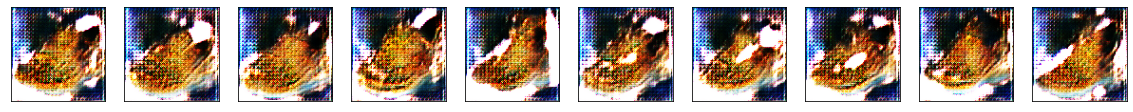

 30%|███       | 122/401 [4:49:09<11:05:11, 143.05s/it]

121 [D loss: 0.03395078843459487, accuracy: 98.44] [Adv loss: 3.0322465896606445, Adv accuracy: 34.38]


 31%|███       | 123/401 [4:51:31<11:02:10, 142.92s/it]

122 [D loss: 1.419854819317834e-05, accuracy: 100.00] [Adv loss: 0.0038036496844142675, Adv accuracy: 100.00]


 31%|███       | 124/401 [4:53:54<10:59:33, 142.87s/it]

123 [D loss: 0.0007103347452357411, accuracy: 100.00] [Adv loss: 0.056321967393159866, Adv accuracy: 100.00]


 31%|███       | 125/401 [4:56:17<10:57:05, 142.84s/it]

124 [D loss: 0.00047573867777828127, accuracy: 100.00] [Adv loss: 0.05912655591964722, Adv accuracy: 100.00]
125 [D loss: 0.09117615688592196, accuracy: 96.88] [Adv loss: 13.701763153076172, Adv accuracy: 0.00]


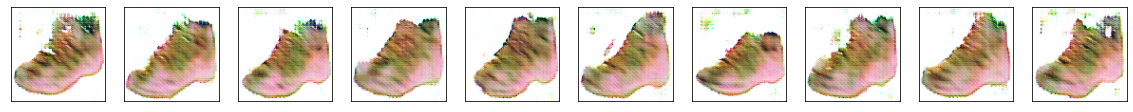

 32%|███▏      | 127/401 [5:01:03<10:52:28, 142.88s/it]

126 [D loss: 0.0190825704485178, accuracy: 100.00] [Adv loss: 2.043311595916748, Adv accuracy: 37.50]


 32%|███▏      | 128/401 [5:03:25<10:49:49, 142.82s/it]

127 [D loss: 0.0019078500918112695, accuracy: 100.00] [Adv loss: 2.689467191696167, Adv accuracy: 28.12]


 32%|███▏      | 129/401 [5:05:48<10:47:01, 142.73s/it]

128 [D loss: 0.00011273567224634462, accuracy: 100.00] [Adv loss: 0.020526979118585587, Adv accuracy: 100.00]


 32%|███▏      | 130/401 [5:08:11<10:45:03, 142.82s/it]

129 [D loss: 0.0007276290416484699, accuracy: 100.00] [Adv loss: 0.7545446157455444, Adv accuracy: 34.38]
130 [D loss: 0.0003672347068812698, accuracy: 100.00] [Adv loss: 5.749448973801918e-05, Adv accuracy: 100.00]


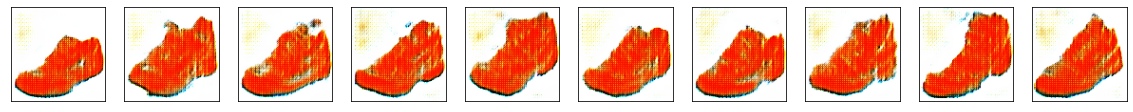

 33%|███▎      | 132/401 [5:12:56<10:39:41, 142.68s/it]

131 [D loss: 0.09945178031921387, accuracy: 96.88] [Adv loss: 0.1882651150226593, Adv accuracy: 93.75]


 33%|███▎      | 133/401 [5:15:19<10:37:39, 142.76s/it]

132 [D loss: 4.922619926076856e-05, accuracy: 100.00] [Adv loss: 0.0015057016862556338, Adv accuracy: 100.00]


 33%|███▎      | 134/401 [5:17:42<10:35:20, 142.77s/it]

133 [D loss: 0.11779828555881977, accuracy: 98.44] [Adv loss: 3.106477975845337, Adv accuracy: 6.25]


 34%|███▎      | 135/401 [5:20:04<10:32:27, 142.66s/it]

134 [D loss: 9.941585813066922e-05, accuracy: 100.00] [Adv loss: 0.00013761551235802472, Adv accuracy: 100.00]
135 [D loss: 0.02067458163946867, accuracy: 98.44] [Adv loss: 1.9701247215270996, Adv accuracy: 34.38]


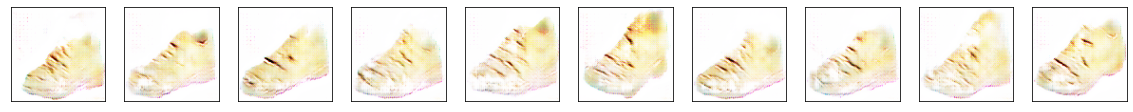

 34%|███▍      | 137/401 [5:24:50<10:27:53, 142.70s/it]

136 [D loss: 0.0019984174286946654, accuracy: 100.00] [Adv loss: 1.7823970317840576, Adv accuracy: 37.50]


 34%|███▍      | 138/401 [5:27:12<10:24:53, 142.56s/it]

137 [D loss: 0.6272742599248886, accuracy: 84.38] [Adv loss: 8.118572235107422, Adv accuracy: 0.00]


 35%|███▍      | 139/401 [5:29:36<10:23:23, 142.76s/it]

138 [D loss: 0.15104687213897705, accuracy: 93.75] [Adv loss: 4.919363975524902, Adv accuracy: 0.00]


 35%|███▍      | 140/401 [5:31:58<10:20:11, 142.57s/it]

139 [D loss: 0.0006114668983521199, accuracy: 100.00] [Adv loss: 0.14302700757980347, Adv accuracy: 90.62]
140 [D loss: 0.06715530343353748, accuracy: 98.44] [Adv loss: 0.0027834689244627953, Adv accuracy: 100.00]


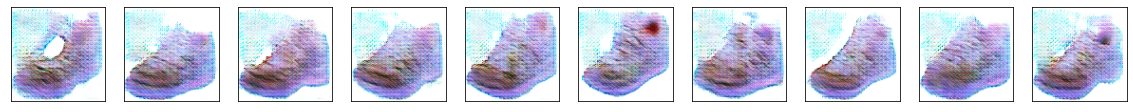

 35%|███▌      | 142/401 [5:36:44<10:16:14, 142.76s/it]

141 [D loss: 0.00025266688583208685, accuracy: 100.00] [Adv loss: 1.20227959996555e-05, Adv accuracy: 100.00]


 36%|███▌      | 143/401 [5:39:06<10:12:49, 142.52s/it]

142 [D loss: 0.0810596183873713, accuracy: 98.44] [Adv loss: 0.8329023718833923, Adv accuracy: 75.00]


 36%|███▌      | 144/401 [5:41:28<10:10:16, 142.48s/it]

143 [D loss: 0.031152463634498417, accuracy: 98.44] [Adv loss: 0.9931257963180542, Adv accuracy: 40.62]


 36%|███▌      | 145/401 [5:43:50<10:07:38, 142.42s/it]

144 [D loss: 0.02682310901582241, accuracy: 100.00] [Adv loss: 0.4982771873474121, Adv accuracy: 75.00]
145 [D loss: 0.029549544909968972, accuracy: 98.44] [Adv loss: 1.1575201749801636, Adv accuracy: 53.12]


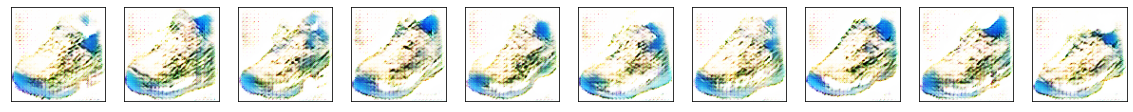

 37%|███▋      | 147/401 [5:48:36<10:03:44, 142.62s/it]

146 [D loss: 0.00010891313286265358, accuracy: 100.00] [Adv loss: 0.015833977609872818, Adv accuracy: 100.00]


 37%|███▋      | 148/401 [5:50:58<10:00:59, 142.53s/it]

147 [D loss: 0.0005818957767278476, accuracy: 100.00] [Adv loss: 1.8243695497512817, Adv accuracy: 21.88]


 37%|███▋      | 149/401 [5:53:21<9:58:56, 142.60s/it] 

148 [D loss: 0.009211140684783459, accuracy: 100.00] [Adv loss: 0.6521477699279785, Adv accuracy: 53.12]


 37%|███▋      | 150/401 [5:55:44<9:56:23, 142.56s/it]

149 [D loss: 0.0005558349075727165, accuracy: 100.00] [Adv loss: 6.7498016357421875, Adv accuracy: 0.00]
150 [D loss: 0.0053613504860550165, accuracy: 100.00] [Adv loss: 1.5295751094818115, Adv accuracy: 25.00]


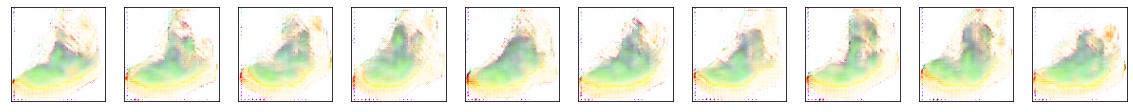

 38%|███▊      | 152/401 [6:00:29<9:51:50, 142.61s/it]

151 [D loss: 0.017029400070896372, accuracy: 98.44] [Adv loss: 0.052961960434913635, Adv accuracy: 96.88]


 38%|███▊      | 153/401 [6:02:52<9:50:14, 142.80s/it]

152 [D loss: 0.0008587574281051502, accuracy: 100.00] [Adv loss: 2.8181755542755127, Adv accuracy: 0.00]


 38%|███▊      | 154/401 [6:05:15<9:47:24, 142.69s/it]

153 [D loss: 7.922297010054535e-05, accuracy: 100.00] [Adv loss: 5.511311428563204e-06, Adv accuracy: 100.00]


 39%|███▊      | 155/401 [6:07:37<9:44:54, 142.66s/it]

154 [D loss: 0.02061050321208313, accuracy: 98.44] [Adv loss: 4.471473948797211e-05, Adv accuracy: 100.00]
155 [D loss: 0.0005675517741110525, accuracy: 100.00] [Adv loss: 0.11278681457042694, Adv accuracy: 100.00]


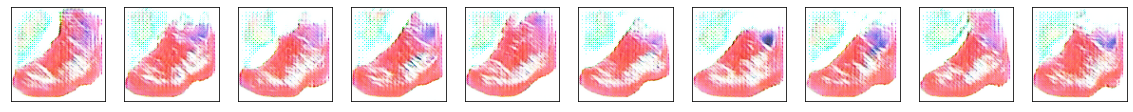

 39%|███▉      | 157/401 [6:12:23<9:40:01, 142.63s/it]

156 [D loss: 1.1637515185012378e-05, accuracy: 100.00] [Adv loss: 16.827159881591797, Adv accuracy: 0.00]


 39%|███▉      | 158/401 [6:14:45<9:36:54, 142.44s/it]

157 [D loss: 0.0013999951879668515, accuracy: 100.00] [Adv loss: 1.4634826183319092, Adv accuracy: 37.50]


 40%|███▉      | 159/401 [6:17:06<9:33:36, 142.22s/it]

158 [D loss: 0.01930487161803285, accuracy: 100.00] [Adv loss: 5.930720329284668, Adv accuracy: 0.00]


 40%|███▉      | 160/401 [6:19:29<9:32:08, 142.44s/it]

159 [D loss: 0.00010556605730061008, accuracy: 100.00] [Adv loss: 0.013169090263545513, Adv accuracy: 100.00]
160 [D loss: 0.0008740405595917267, accuracy: 100.00] [Adv loss: 4.869257926940918, Adv accuracy: 0.00]


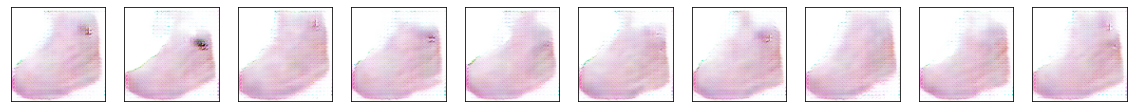

 40%|████      | 162/401 [6:24:14<9:27:20, 142.43s/it]

161 [D loss: 0.015437542810104787, accuracy: 98.44] [Adv loss: 0.8773431777954102, Adv accuracy: 71.88]


 41%|████      | 163/401 [6:26:37<9:25:14, 142.50s/it]

162 [D loss: 0.001687995123120345, accuracy: 100.00] [Adv loss: 1.1127221584320068, Adv accuracy: 40.62]


 41%|████      | 164/401 [6:29:00<9:23:35, 142.68s/it]

163 [D loss: 2.1078221692505394e-05, accuracy: 100.00] [Adv loss: 14.080059051513672, Adv accuracy: 0.00]


 41%|████      | 165/401 [6:31:23<9:20:58, 142.62s/it]

164 [D loss: 0.1669098623096943, accuracy: 96.88] [Adv loss: 1.2762922048568726, Adv accuracy: 50.00]
165 [D loss: 0.0009809457405935973, accuracy: 100.00] [Adv loss: 1.175959825515747, Adv accuracy: 59.38]


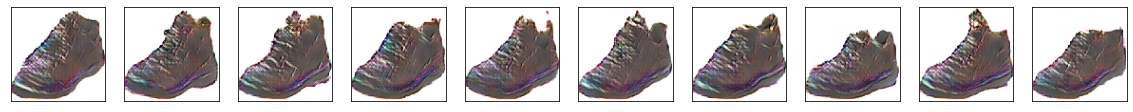

 42%|████▏     | 167/401 [6:36:08<9:16:23, 142.67s/it]

166 [D loss: 0.0009089012164622545, accuracy: 100.00] [Adv loss: 0.019954536110162735, Adv accuracy: 100.00]


 42%|████▏     | 168/401 [6:38:31<9:13:59, 142.66s/it]

167 [D loss: 0.020516271702945232, accuracy: 98.44] [Adv loss: 0.3384009301662445, Adv accuracy: 87.50]


 42%|████▏     | 169/401 [6:40:54<9:12:00, 142.76s/it]

168 [D loss: 9.434772418881465e-08, accuracy: 100.00] [Adv loss: 1.1347551345825195, Adv accuracy: 50.00]


 42%|████▏     | 170/401 [6:43:16<9:09:25, 142.71s/it]

169 [D loss: 2.3709665356363985e-05, accuracy: 100.00] [Adv loss: 5.122178554534912, Adv accuracy: 0.00]
170 [D loss: 0.02278246624877056, accuracy: 98.44] [Adv loss: 11.516277313232422, Adv accuracy: 0.00]


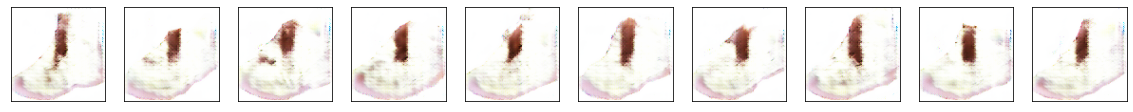

 43%|████▎     | 172/401 [6:48:02<9:04:16, 142.60s/it]

171 [D loss: 0.0007077821255734307, accuracy: 100.00] [Adv loss: 0.6582081317901611, Adv accuracy: 78.12]


 43%|████▎     | 173/401 [6:50:24<9:01:12, 142.43s/it]

172 [D loss: 0.00037386158644103773, accuracy: 100.00] [Adv loss: 0.011957032606005669, Adv accuracy: 100.00]


 43%|████▎     | 174/401 [6:52:46<8:59:08, 142.51s/it]

173 [D loss: 0.05504228174686432, accuracy: 98.44] [Adv loss: 2.790865659713745, Adv accuracy: 21.88]


 44%|████▎     | 175/401 [6:55:08<8:56:14, 142.37s/it]

174 [D loss: 2.2501016815112962e-05, accuracy: 100.00] [Adv loss: 0.0012558561284095049, Adv accuracy: 100.00]
175 [D loss: 0.026876545819959574, accuracy: 98.44] [Adv loss: 1.0330192718437041e-24, Adv accuracy: 100.00]


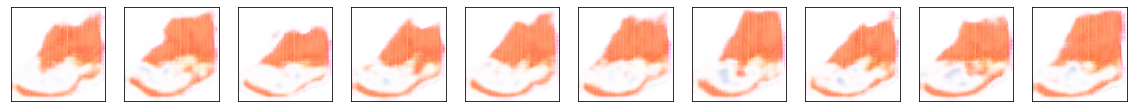

 44%|████▍     | 177/401 [6:59:53<8:50:48, 142.18s/it]

176 [D loss: 4.4969189730181824e-05, accuracy: 100.00] [Adv loss: 0.005746557842940092, Adv accuracy: 100.00]


In [ ]:
epochs = 401
batch_size = 32
ite_to_save = 5
# need to add these for the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

train(train_gen, epochs, batch_size, ite_to_save)

In [ ]:
#Plot the final results 
noise_input = np.random.normal(0, 1, size=[32, z_dim])
plot_images(gen, noise_input,
            show=True,
            file_name="images/Latent256/2000000")

#### Plot the Losses Accuracies for Discriminator and Adversarial

In [ ]:
loss_history = np.array(losses)
acc_history = np.array(accuracies)

dloss = loss_history[:, 0]
dacc = acc_history[:, 0]

advloss = loss_history[:, 1]
advacc = acc_history[:, 1]

print(dloss.shape)

In [ ]:
# let us plot the loss vs. epochs
epoch = np.arange(0,len(dloss))
fig, ax = plt.subplots()
ax.plot(epoch, dloss,label='discriminator loss')
ax.plot(epoch, advloss,label='adverserial loss')
leg = ax.legend();
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# let us plot the loss vs. epochs
epoch = np.arange(0,len(dloss))
fig, ax = plt.subplots()
ax.plot(epoch, dacc,label='discriminator acc')
ax.plot(epoch, advacc,label='adverserial acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
leg = ax.legend();
plt.show()

In [ ]:

#Defining the combined model of the Generator and the Discriminator 
generater_loaded = tf.keras.models.load_model('savedModelsDCLatent256/dcgen_285.h5') 
generater_loaded.summary()

## Evaluation Part
NOTE #1: Don't Forget to add the needed libraries (Can be found at the first cell) 

NOTE #2: If you need t increase the number of images, change the batch_size, the max number is 28701 images (available real) 

#### FID Score

In [ ]:
batch_size = 1000
width = 100
path = '/home/group6/G.Deep Learning/Project/Shoes-dataset'
Img_generator=ImageDataGenerator(rescale=1./255)
train_gen=Img_generator.flow_from_directory(path, classes=[''], target_size=(width,width),batch_size=batch_size,shuffle=False)

In [ ]:
img_shape = (width, width, 3)
z_dim = 256
num_batches = math.floor(28701/batch_size)
num_batches

In [ ]:
#Read the saved generator model
generater_loaded = tf.keras.models.load_model('savedModelsDCLatent256/dcgen_285.h5') 
generater_loaded.summary()

In [ ]:
z = np.random.normal(0, 1, size=[100, z_dim])
gen_imgs = generater_loaded.predict(z)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
        # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
    #     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def generate_images(imgs_number=100):
    z = np.random.normal(0, 1, size=[imgs_number, z_dim])
    gen_imgs = generater_loaded.predict(z)
    return gen_imgs

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, img1, img2):
    act1 = model.predict(img1)
    act2 = model.predict(img2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
!pip install scikit-image

In [ ]:
#scale function (299, 299, 3)
from skimage.transform import resize 
# need to first make it the right size
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
#Prepare the input images to be used for FID 
#Use 100 images for FID score
#Get rel images 
real_images_origin = train_gen.next()
real_images_origin = real_images_origin[0]
fake_images_origin = generate_images(batch_size)
# #convert the int to float
real_images = real_images_origin.astype('float32')
fake_images = fake_images_origin.astype('float32')
#rescale the images 
real_images = scale_images(real_images, (299,299,3))
fake_images = scale_images(fake_images, (299,299,3))
#Preprocess the images 
real_images = preprocess_input(real_images)
fake_images = preprocess_input(fake_images)

In [ ]:
#Calculate the FID score
fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

### Inception Score

In [ ]:
def calculate_inception_score(images, n_split=5, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # predict class probabilities for images
    yhat = model.predict(images)
    # enumerate splits of images/predictions
    scores = list()
    # calculate the score in batches 
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve p(y|x) these are [0, 0.5, 0, 0.5], etc.
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

In [ ]:
# calculate the inception score 
iscore = calculate_inception_score(fake_images)
print(iscore)

### KNN Method

In [ ]:
#Flatten the imgs
real_images = real_images_origin.reshape((-1, 100*100*3))
fake_images = fake_images_origin.reshape((-1, 100*100*3))

#Create labels
y_real = np.ones(batch_size)
y_fake = np.zeros(batch_size)

x = np.vstack((real_images, fake_images))
y = np.hstack((y_real, y_fake))

print(x.shape)
print(y.shape)

In [ ]:
#https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python
    
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


In [ ]:
# nbrs = KNeighborsClassifier(n_neighbors=1,  metric='pyfunc',metric_params={"func":calculate_psnr})
nbrs = KNeighborsClassifier(n_neighbors=1,  metric=calculate_psnr)

from tqdm import tqdm

loo = LeaveOneOut()

scores = list()
for train, test in tqdm(loo.split(x)):
    #fit the model leaving one out
    knn_model= nbrs.fit(x[train],y[train])
    predicted = knn_model.predict(x[test])
    actual = y[test]
    scores.append(accuracy_score(actual,predicted))

In [ ]:
print(np.array(scores).mean())
print(np.array(scores).std())


In [ ]:
#Display images with a loaded generator
noise_input = np.random.normal(0, 1, size=[32, z_dim])

z = noise_input
gen_imgs = generater_loaded.predict(z)
n = 5  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
        # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
    #     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print(z.shape)
print(gen_imgs.shape)